# Brain tumor detection model

This notebook uses deep learning to classify MRI and X-ray images for early brain tumor and lung cancer detection. Developed with TensorFlow and Keras, it addresses diagnostic challenges in low-resource healthcare settings like Rwanda.

### Loading dependencies

In [132]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Precision, Recall
from keras.regularizers import l2
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Loading Data and data preprocessing

In [133]:
# Directories
training_dir = "../data/training"
validation_dir = "../data/validation"

# Initialize ImageDataGenerators
datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training generator
train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=(64, 64),
    batch_size=32,
    color_mode="grayscale",  # Grayscale images
    class_mode="categorical",  # Multi-class classification
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),
    batch_size=32,
    color_mode="grayscale",  # Grayscale images
    class_mode="categorical",  # Multi-class classification
)

Found 217 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [134]:
def plot_images_from_path(path, num_images=3):
    images = os.listdir(path)
    plt.figure(figsize=(20, 20))

    random_images = random.sample(images, min(num_images, len(images)))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(300, 300))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Image {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

#### visualise tumor images

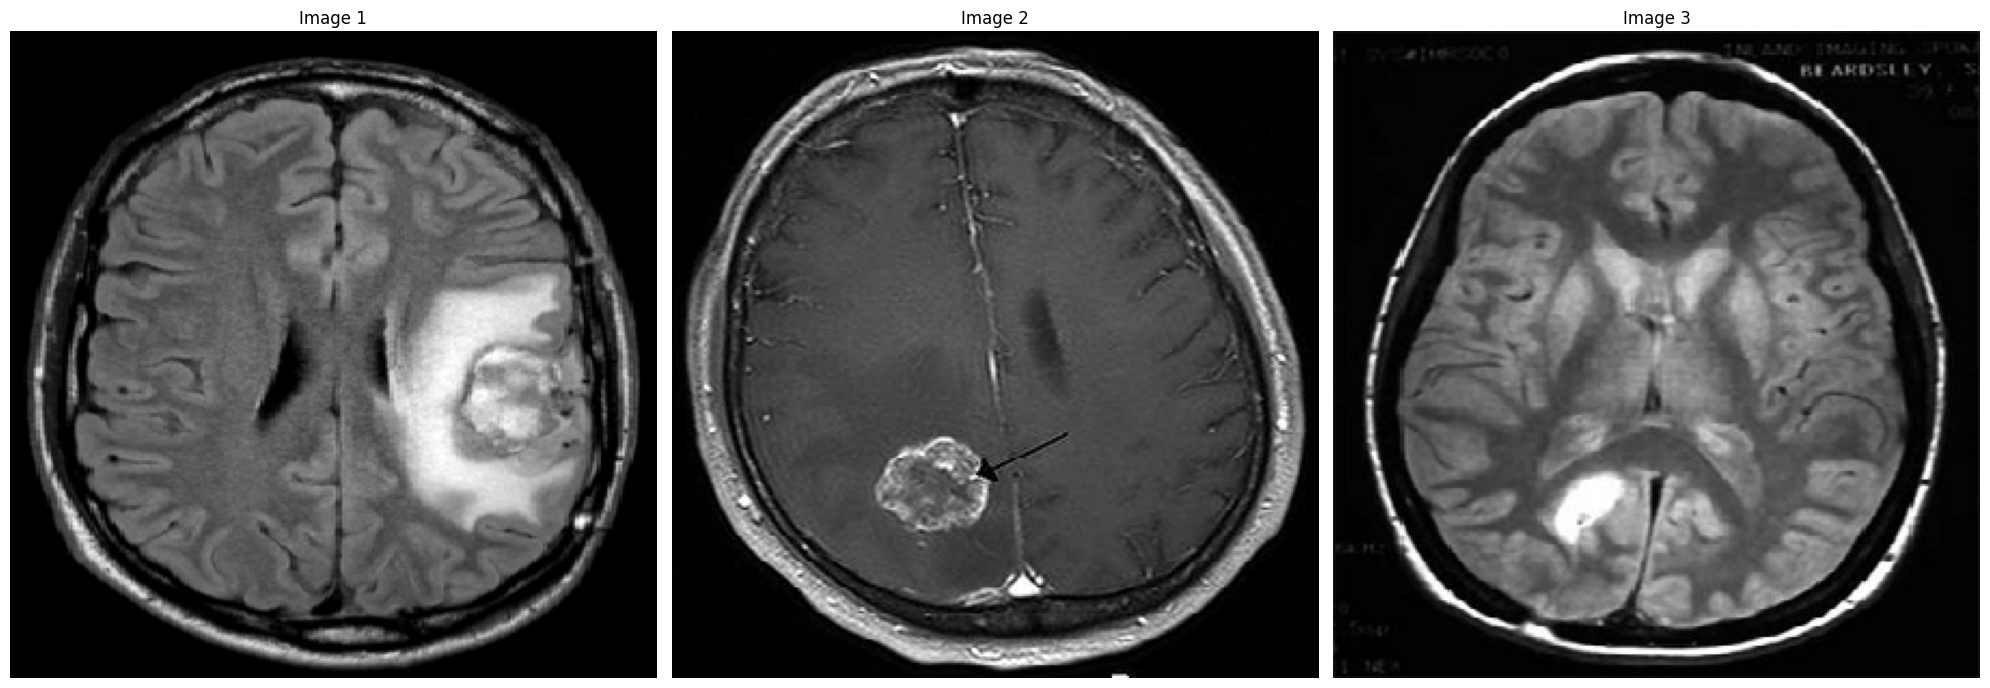

In [135]:
plot_images_from_path("../data/training/yes")

#### visualise No Tumor Images

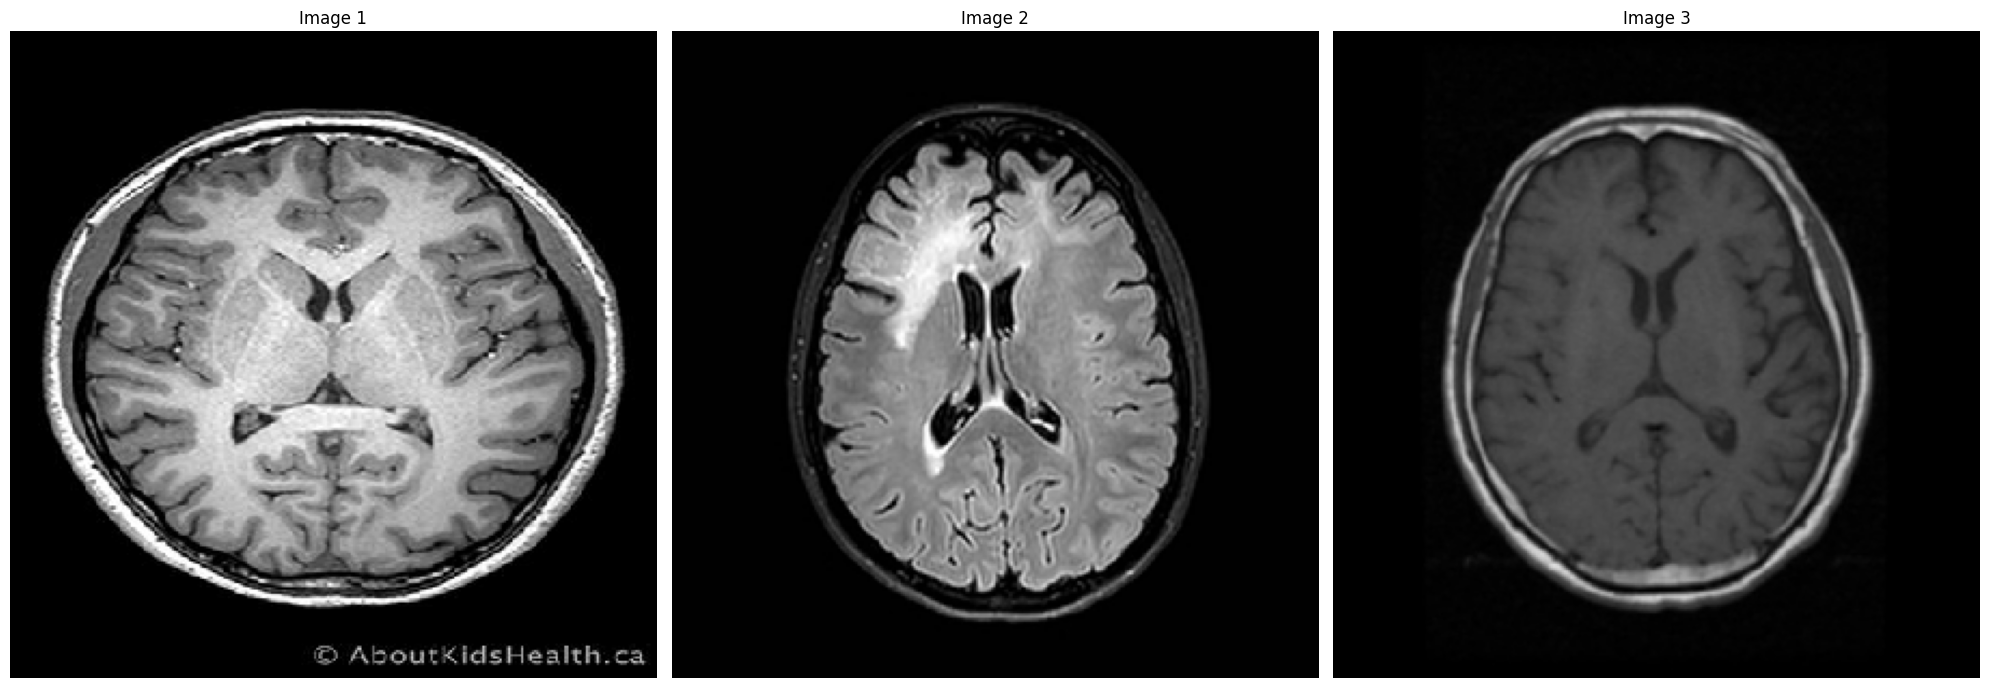

In [136]:
plot_images_from_path("../data/training/no")

### Model1 Architecture

In [137]:
model = Sequential()

noOfFilter1 = 32
noOfFilter2 = 64
sizeOfFilter1 = (3, 3)
sizeOfFilter2 = (3, 3)
sizeOfPool = (2, 2)
noOfNodes = (16, 32, 64, 128)
input_shape = (64, 64, 1)


model.add(
    Conv2D(noOfFilter1, sizeOfFilter1, activation="relu", input_shape=input_shape)
)
model.add(MaxPooling2D(pool_size=sizeOfPool))

model.add(Conv2D(noOfFilter2, sizeOfFilter2, activation="relu"))
model.add(MaxPooling2D(pool_size=sizeOfPool))

model.add(Flatten())

model.add(Dense(noOfNodes[2], activation="relu"))
model.add(Dense(noOfNodes[1], activation="relu"))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)
model.summary()

/opt/anaconda3/envs/job/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,842 (3.14 MB)

 Trainable params: 823,842 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

#### plotting & Analysis function

In [138]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()
    return

def display_accuracy(history):
    model1_training_accuracy = history.history["accuracy"][-1] * 100 
    model1_validation_accuracy = history.history["val_accuracy"][-1] * 100

    print(f"Final Training Accuracy: {model1_training_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {model1_validation_accuracy:.2f}%")
    return

def display_confusion_matrix(trained_model):
    validation_generator.reset()
    predictions = trained_model.predict(validation_generator, verbose=1)

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())
    conf_matrix = confusion_matrix(predicted_classes, true_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

#### callbacks

In [139]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
check_point = ModelCheckpoint(filepath='callbacks/model_checkpoint.keras', save_best_only=True, mode='auto', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001)

#### train model

In [140]:
model_history = model.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop, check_point, reduce_lr]
)
model.save("../models/brain_tumor_model.keras")
model.save("../models/brain_tumor_model.h5")

/opt/anaconda3/envs/job/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6957 - loss: 0.6023 - precision_11: 0.6957 - recall_11: 0.6957
Epoch 1: val_loss improved from inf to 0.57922, saving model to callbacks/model_checkpoint.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.6957 - loss: 0.5995 - precision_11: 0.6957 - recall_11: 0.6957 - val_accuracy: 0.7222 - val_loss: 0.5792 - val_precision_11: 0.7222 - val_recall_11: 0.7222 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7912 - loss: 0.5323 - precision_11: 0.7912 - recall_11: 0.7912
Epoch 2: val_loss improved from 0.57922 to 0.48802, saving model to callbacks/model_checkpoint.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.7902 - loss: 0.5320 - precision_11: 0.7902 - recall_11: 0.7902 - val_accuracy: 0.7778 - val_loss: 0.4880 - val_precision_11: 0.7778 - val_recall_11: 0.7778 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7845 - loss: 0.477

#### model error analysis

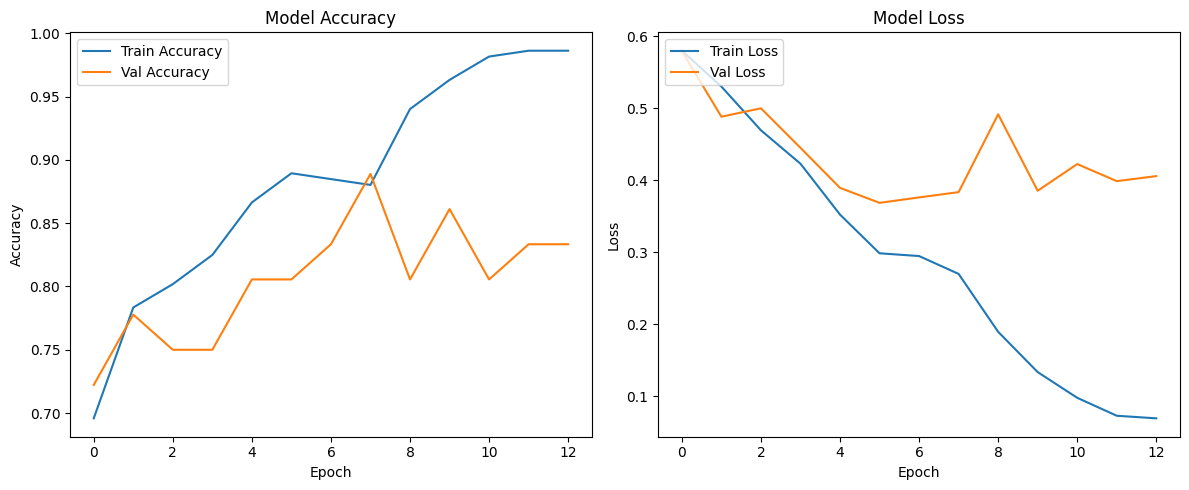

In [141]:
plot_history(model_history)

In [142]:
display_accuracy(model_history)

Final Training Accuracy: 98.62%
Final Validation Accuracy: 83.33%


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


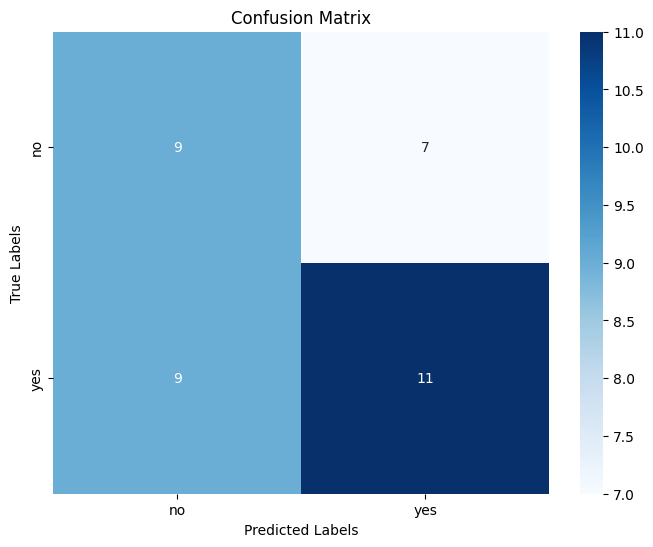

              precision    recall  f1-score   support

          no       0.56      0.50      0.53        18
         yes       0.55      0.61      0.58        18

    accuracy                           0.56        36
   macro avg       0.56      0.56      0.55        36
weighted avg       0.56      0.56      0.55        36



In [143]:
display_confusion_matrix(model)

In [144]:
image = load_img("../data/training/yes/Y20.jpg", target_size=(64, 64), color_mode="grayscale")
input_arr = img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted Class: {predicted_class} - {validation_generator.class_indices}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted Class: [1] - {'no': 0, 'yes': 1}
